# GNN for link prediction

Train GNN on a link prediction task: Given an event graph, decide whether links (edges) denoting origin from the same particle shower exist between tracksters. As in the MLP and the node classification case, tracksters above a certain energy threshold are selected first (Selected Tracksters), then their cylindrical neighborhoods are searched for candidate tracksters, and the network evaluates connections to those. For a detailed description of the methods, refer to the [Master Thesis Text](https://www.merlin.uzh.ch/publication/show/23612).

### Problem setup

This notebook covers preprocessing the ROOT files into PyTorch datasets, model training, and evaluation against the baselines. ONNX export for the graph models is currently not supported due to `torch_cluster` modules. The reconstruction process consists of the following steps:

### Dataset preprocessing

First, the ROOT files are preprocessed into a PyTorch dataset.

#### 1. Select tracksters above a certain energy threshold

Select a high-energy trackster to run the smoothing around. The energy threshold is a fine-tined parameter. Generally, 10 - 50 GeV was found to work well. This notebook covers the pile-up scenario, where simtracksters are only present for selected particle showers in the event. Therefore, only tracksters with at least 50% energy from the examined simtracksters are considered in training.

**Result**: Selected Tracksters.

#### 2. Get tracksters in the cylindrical neighborhood of Selected Tracksters

The cylinder is defined along the axis connecting the trackster barycenter to 0,0,0 and a selected radius (e.g., 15cm). Tracksters within this radius are considered the Candidate Tracksters.

**Result**: Event graphs around the Selected Trackster

### Model training

The model runs on event graphs (one graph per event) and evaluates connections between Selected Tracksters and their cylindrical neighborhoods. The prediction is computed per edge. Edges of interest are pre-computed using the Selected Tracksters and their neighborhoods and queried after the last EdgeConv block in the network. The model is based on the ParticleNet architecture, with the first block of EdgeConv considering the neighbors in the trackster barycenter space. Then, the two following EdgeConv blocks are dynamic and search for nearest neighbors in the latent spaces. Finally, the node features of queried trackster pairs are concatenated and passed through a dense layer. As the model predicts a binary label per edge, we use a `QualityFocalLoss` function (based on binary cross entropy); see `reco.loss` for implementation and the [Master Thesis Text](https://www.merlin.uzh.ch/publication/show/23612) for theoretical background.

### Inference event reconstruction

In this case, the event reconstruction is trivial: merge all tracksters connected by an edge that is predicted to be true.

#### Evaluation

The improvement in the event reconstruction is evaluated using B-CUBED metrics and compared against the baselines.

## Data location

Set `ds_name` to the dataset name, and point `raw_dir` to the directory containing ntuplized `.root` files.
Processed `PyTorch` datasets will be placed in the `data_root` folder. The program will verify if the requested datasets exist already. Make sure the directories exist.

In [1]:
ds_name = "CloseByPion200PU"
raw_dir = "/home/ecuba/data/CloseByPion200PU"
data_root = "/home/ecuba/data/processed"
model_dir = "models"

## Initialization

In [2]:
import torch
import sys

import numpy as np

import torch.nn as nn
from torch_cluster import knn_graph
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

import torch_geometric.nn as gnn

from reco.model import DynamicEdgeConvBlock, EdgeConvBlock

from reco.training import precision_recall_curve, roc_auc, train_link_prediction, test_link_prediction
from reco.loss import QualityFocalLoss
from reco.dataset_graph import TracksterGraph

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load or process the dataset

At least `N_FILES=100` root files is recommended to have a large enough training sample.
The following parameters need to be set:
- `bigT_e_th`: energy threshold to select tracksters for smoothing
- `radius`: radius of the cylinder around the selected tracksters
- `pileup`: needs to be set to `true` for pile-up datasets, the selection of the tracksters is limited to ones that overlap with a simtrackster
- `link_prediction`: controls the problem setup, should be set to `True` for link prediction

The following cell will load (if available) or preprocess the root files into a PyTorch dataset. See the class `TracksterGraph` for more details.

In [4]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=400,
    radius=15,
    bigT_e_th=5,
    link_prediction=True,
)
ds

TracksterGraphPU(graphs=7569, nodes=341008, radius=15, bigT_e_th=5, lp)

## Split the dataset into train and validation

In [5]:
val_set_fraction = 0.1

ds_size = len(ds)
val_set_size = ds_size // int(1. / val_set_fraction)
train_set_size = ds_size - val_set_size
train_set, val_set = random_split(ds, [train_set_size, val_set_size])
print(f"Train sub-graphs: {len(train_set)}, Validation sub-graphs: {len(val_set)}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
val_dl = DataLoader(val_set, batch_size=8, shuffle=True)

Train sub-graphs: 6813, Validation sub-graphs: 756


## Model configuration

Configure model and training setup. Here, we use a ParticleNet inspired model with three EdgeConv blocks followed by two dense layers.
The first EdgeConv block is using a k-nn based on the trackster barycenters, the remaining two layers compute the nearest neighbors in the latent space.
The output is a binary class probability for each edge defined by the `edge_index`.

In [6]:
class LinkPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(LinkPredictionNet, self).__init__()
        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 32
        hdim2 = 64
        hdim3 = 64
        hdim_fc = 128

        self.input_edgeconv = EdgeConvBlock(input_dim, hdim1)
        self.edgeconv1 = DynamicEdgeConvBlock(hdim1, hdim2, k=8)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim2, hdim3, k=8)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(2 * hdim3, hdim_fc),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
        )

    def forward(self, X, pos, edge_index, batch=None):
        
        # only use the pos for the initial knn
        init_knn = knn_graph(pos, batch=batch, k=8, loop=False)
        H0 = self.input_edgeconv(X, init_knn)
        H1 = self.edgeconv1(H0, batch=batch)
        H2 = self.edgeconv2(H1, batch=batch)
        
        src, dst = edge_index
        edges = torch.cat([H2[src], H2[dst]], dim=-1)
        return self.nodenetwork(edges).squeeze(-1)

In [7]:
model = LinkPredictionNet(input_dim=ds.x.shape[1])
epochs = 51
model_path = f"{model_dir}/LinkPredictionNet.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

## Training

Train the model and compute validation loss.

In [16]:
# skip this cell if you have a pre-trained model available
loss_func = QualityFocalLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_link_prediction(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_link_prediction(model, device, loss_func, val_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )

# save the model
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 60.571	 validation loss: 44.974
Epoch 5:	 train loss: 35.091	 validation loss: 34.387
Epoch 10:	 train loss: 32.780	 validation loss: 34.483
Epoch 15:	 train loss: 31.282	 validation loss: 31.477
Epoch 20:	 train loss: 30.311	 validation loss: 31.591
Epoch 25:	 train loss: 29.425	 validation loss: 31.237
Epoch 30:	 train loss: 28.969	 validation loss: 31.070
Epoch 35:	 train loss: 28.285	 validation loss: 30.336
Epoch 40:	 train loss: 27.772	 validation loss: 30.112
Epoch 45:	 train loss: 27.395	 validation loss: 30.013


models/LinkPredictionNet.51e-CloseByPion200PU.r15.e5.f400.pt


Epoch 50:	 train loss: 27.250	 validation loss: 29.971


In [8]:
# load a pre-trained model
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

0.95172691417781


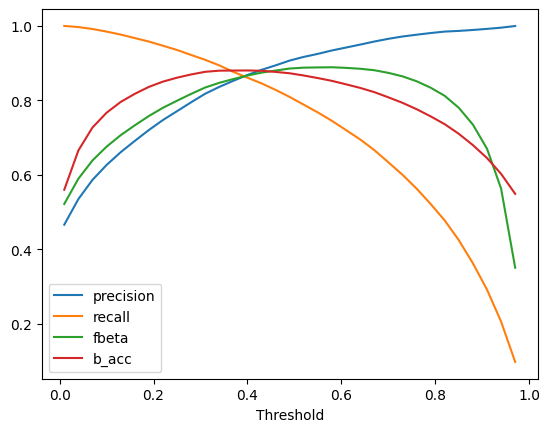

TP: 22757, TN: 38171, FP: 1614, FN: 7805
TH: 0.58 precision: 0.934 recall: 0.745 fbeta: 0.889 b_acc: 0.852


In [9]:
print(roc_auc(model, device, val_dl))
precision_recall_curve(model, device, val_dl, step=3, truth_threshold=0.5)

## Evaluation

Evaluate the model performance on an unseen set of events across different radius settings.
For each selected trackster (energy above threshold), classify links to all tracksters in the cylindrical neighborhood.

In [9]:
import matplotlib.pyplot as plt
from reco.data import get_event_data
from reco.evaluation import model_evaluation

file_name = f"{raw_dir}/test/test_samples_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [10]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model.to("cpu"),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
        link_prediction=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 3 ---
Event 0:
	No data
Event 1:
	No data
Event 2:
	clue3d_to_sim:	P: 0.897 R: 0.302 F: 0.644
	target_to_sim:	P: 0.891 R: 0.323 F: 0.660
	reco_to_sim:	P: 0.897 R: 0.302 F: 0.644
	|Sim| = 1 |Target| = 1 |Reco| = 1
Event 3:
	clue3d_to_sim:	P: 0.973 R: 0.704 F: 0.904
	target_to_sim:	P: 0.973 R: 0.704 F: 0.904
	reco_to_sim:	P: 0.973 R: 0.704 F: 0.904
	|Sim| = 1 |Target| = 1 |Reco| = 1
Event 4:
	clue3d_to_sim:	P: 0.535 R: 0.483 F: 0.523
	target_to_sim:	P: 0.535 R: 0.483 F: 0.523
	reco_to_sim:	P: 0.535 R: 0.483 F: 0.523
	|Sim| = 1 |Target| = 1 |Reco| = 1
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.256 F: 0.632
	target_to_sim:	P: 1.000 R: 0.277 F: 0.657
	reco_to_sim:	P: 1.000 R: 0.277 F: 0.657
	|Sim| = 1 |Target| = 3 |Reco| = 3
Event 6:
	No data
Event 7:
	clue3d_to_sim:	P: 1.000 R: 0.080 F: 0.304
	target_to_sim:	P: 1.000 R: 0.159 F: 0.487
	reco_to_sim:	P: 1.000 R: 0.159 F: 0.487
	|Sim| = 1 |Target| = 1 |Reco| = 1
Event 8:
	clue3d_to_sim:	P: 0.979 R: 0.504 F: 0.823
	target_to

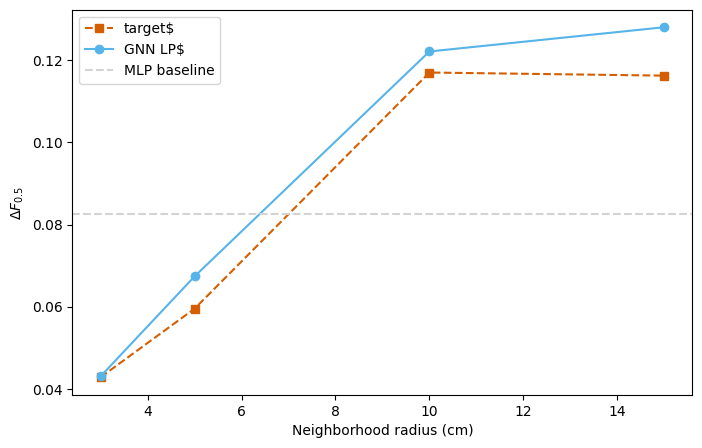

In [12]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN LP$", c="#56B4E9")
ax.axhline(0.0825, label="MLP baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")

plt.show()